# **TensorFlow**

In [ ]:
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt

In [ ]:
import os

DATASET_PATH = "/content/drive/MyDrive/facadates"
trainA_path = os.path.join(DATASET_PATH, "trainA")
trainB_path = os.path.join(DATASET_PATH, "trainB")
testA_path = os.path.join(DATASET_PATH, "testA")
testB_path = os.path.join(DATASET_PATH, "testB")

print(os.listdir(trainA_path)[:5])
print(os.listdir(trainB_path)[:5])

['109_A.jpg', '10_A.jpg', '116_A.jpg', '113_A.jpg', '101_A.jpg']
['101_B.jpg', '109_B.jpg', '10_B.jpg', '105_B.jpg', '104_B.jpg']


In [ ]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
BUFFER_SIZE = 400
BATCH_SIZE = 1

In [ ]:
def load_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = (img / 127.5) - 1   # Normalize to [-1, 1]
    return img

In [ ]:
trainA_files = sorted(glob.glob(os.path.join(trainA_path, "*.jpg")))
trainB_files = sorted(glob.glob(os.path.join(trainB_path, "*.jpg")))

print(len(trainA_files), len(trainB_files))


400 400


In [ ]:
def load_train_pair(a_path, b_path):
    input_img = load_image(a_path)
    target_img = load_image(b_path)
    return input_img, target_img

train_dataset = tf.data.Dataset.from_tensor_slices((trainA_files, trainB_files))
train_dataset = train_dataset.map(load_train_pair, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-mbk7obn8
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-mbk7obn8
  Resolved https://github.com/tensorflow/examples.git to commit 3c7435733a9162481df350e57c53e58d2a705e4d
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1746868094.345130988853936603129253091149118257392589495885-py3-none-any.whl size=301646 sha256=7806bde817f15b76c361662720b3b5b9e6a4aa2b83f7505e5451b370b670f77c
  Stored in directory: /tmp/pip-ephem-wheel-cache-2cdbj6ev/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
generator = pix2pix.unet_generator(3, norm_type='batchnorm')

In [ ]:
discriminator = pix2pix.discriminator(norm_type='batchnorm', target=True)


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [ ]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Rescale images from [-1,1] to [0,1]
        plt.imshow((display_list[i] + 1) / 2.0)
        plt.axis('off')
    plt.show()

Epoch 1 Step 0
Epoch 1 Step 100
Epoch 1 Step 200
Epoch 1 Step 300
Time taken for epoch 1 is 346.1767785549164 sec



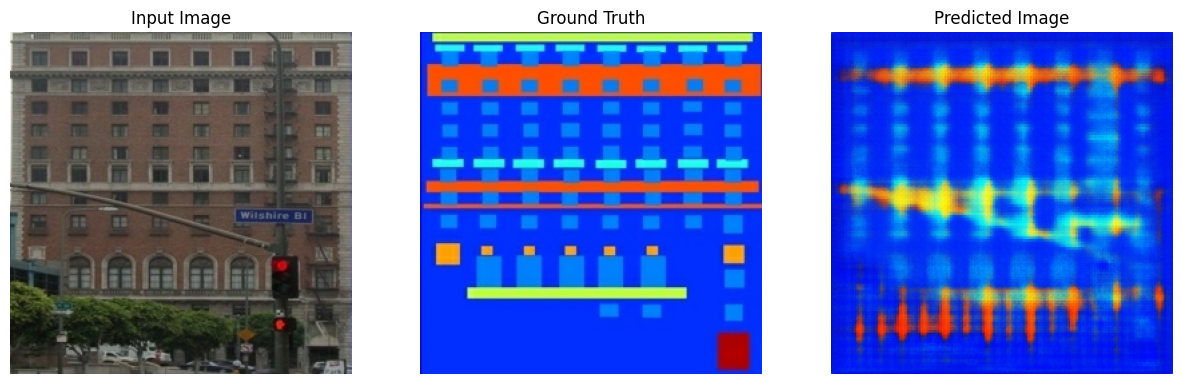

Epoch 2 Step 0
Epoch 2 Step 100
Epoch 2 Step 200
Epoch 2 Step 300
Time taken for epoch 2 is 46.623530626297 sec



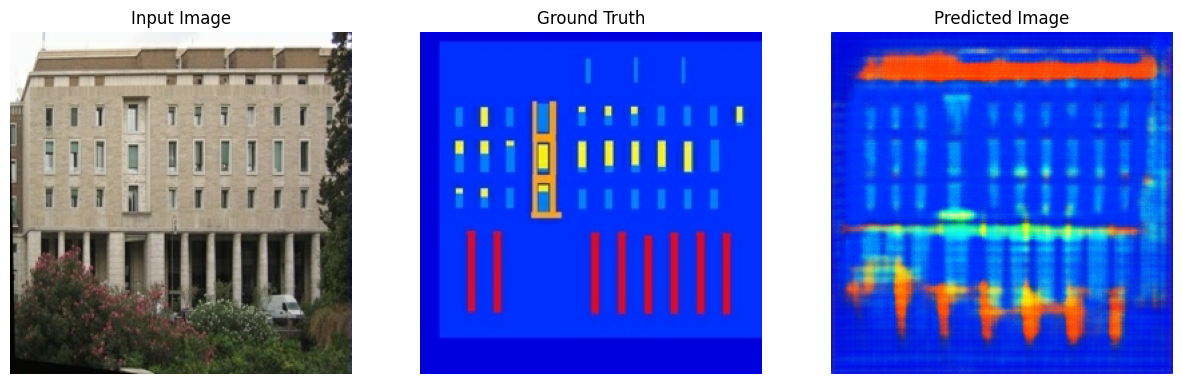

Epoch 3 Step 0
Epoch 3 Step 100
Epoch 3 Step 200
Epoch 3 Step 300
Time taken for epoch 3 is 46.86729550361633 sec



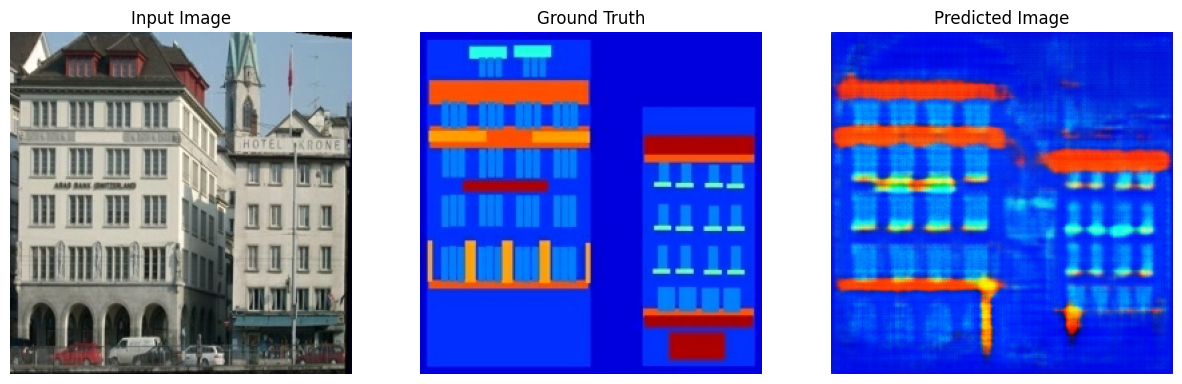

Epoch 4 Step 0
Epoch 4 Step 100
Epoch 4 Step 200
Epoch 4 Step 300
Time taken for epoch 4 is 81.92943787574768 sec



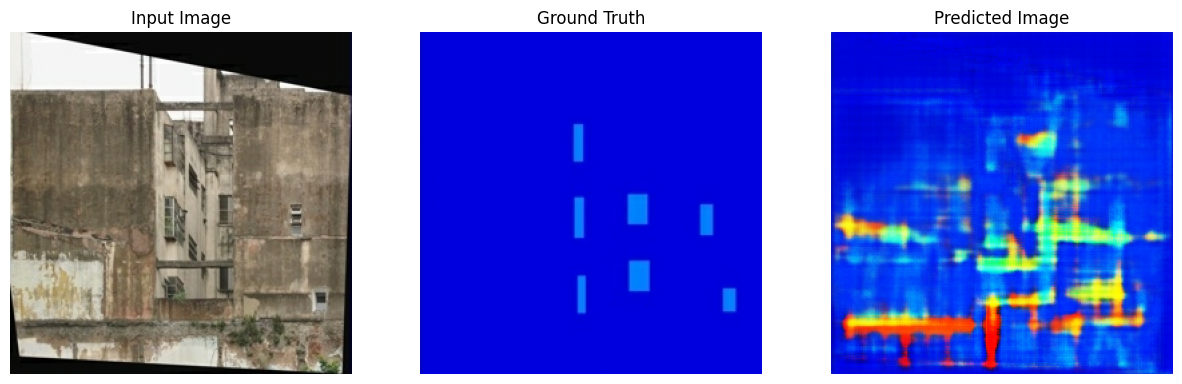

Epoch 5 Step 0
Epoch 5 Step 100
Epoch 5 Step 200
Epoch 5 Step 300
Time taken for epoch 5 is 47.126468896865845 sec



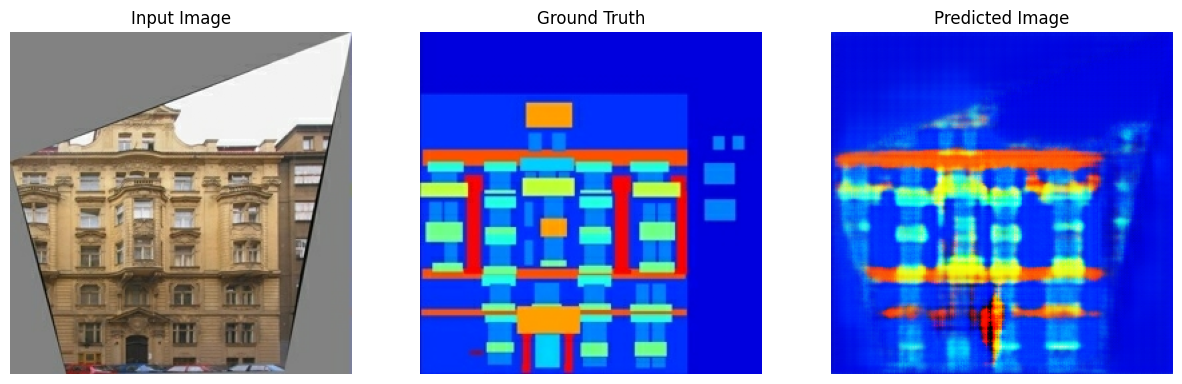

In [ ]:
import time

EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    for n, (input_image, target) in train_dataset.enumerate():
        train_step(input_image, target)

        if n % 100 == 0:
            print(f"Epoch {epoch+1} Step {n.numpy()}")

    print(f"Time taken for epoch {epoch+1} is {time.time()-start} sec\n")

    # Visualize on one sample
    for example_input, example_target in train_dataset.take(1):
        generate_images(generator, example_input, example_target)


In [ ]:
generator.save("/content/drive/MyDrive/pix2pix_generator_model.keras")

In [ ]:
model.save("my_model.keras")

NameError: name 'model' is not defined

# **PyTorch**

In [ ]:
pip install torch torchvision matplotlib pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install torch torchvision matplotlib

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
class FacadesDataset(Dataset):
    def __init__(self, path_A, path_B, transform=None):
        self.path_A = path_A
        self.path_B = path_B
        self.transform = transform

        # List all *_A.jpg files
        files_A = sorted([f for f in os.listdir(path_A) if f.endswith('_A.jpg')])
        self.basenames = [f.split('_')[0] for f in files_A]

    def __len__(self):
        return len(self.basenames)

    def __getitem__(self, idx):
        base = self.basenames[idx]
        img_A_path = os.path.join(self.path_A, f"{base}_A.jpg")
        img_B_path = os.path.join(self.path_B, f"{base}_B.jpg")

        img_A = Image.open(img_A_path).convert("RGB")
        img_B = Image.open(img_B_path).convert("RGB")

        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return img_A, img_B

In [ ]:
DATA_DIR = "/content/drive/MyDrive/facades"

trainA_path = os.path.join(DATA_DIR, "trainA")
trainB_path = os.path.join(DATA_DIR, "trainB")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

dataset = FacadesDataset(trainA_path, trainB_path, transform=transform)
train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Quick check
for a, b in train_loader:
    print(a.shape, b.shape)
    break

torch.Size([1, 3, 256, 256]) torch.Size([1, 3, 256, 256])


In [ ]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        e = self.encoder(x)
        d = self.decoder(e)
        return d

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        xy = torch.cat([x, y], dim=1)
        return self.model(xy)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = UNetGenerator().to(device)
discriminator = Discriminator().to(device)

loss_fn = nn.BCELoss()
l1_loss = nn.L1Loss()

optimizer_g = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
for epoch in range(1):  # use higher number for real training
    for i, (input_img, target_img) in enumerate(train_loader):
        input_img, target_img = input_img.to(device), target_img.to(device)

        ### Train Discriminator ###
        fake_img = generator(input_img)
        real_label = torch.ones_like(discriminator(input_img, target_img))
        fake_label = torch.zeros_like(discriminator(input_img, fake_img.detach()))

        real_pred = discriminator(input_img, target_img)
        fake_pred = discriminator(input_img, fake_img.detach())

        d_loss_real = loss_fn(real_pred, real_label)
        d_loss_fake = loss_fn(fake_pred, fake_label)
        d_loss = d_loss_real + d_loss_fake

        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        ### Train Generator ###
        fake_pred = discriminator(input_img, fake_img)
        g_adv_loss = loss_fn(fake_pred, real_label)
        g_l1_loss = l1_loss(fake_img, target_img)
        g_loss = g_adv_loss + 100 * g_l1_loss

        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}], Step [{i}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch [1], Step [0], D Loss: 1.3923, G Loss: 47.3242
Epoch [1], Step [10], D Loss: 0.9218, G Loss: 37.1546
Epoch [1], Step [20], D Loss: 1.1454, G Loss: 26.4407
Epoch [1], Step [30], D Loss: 1.2512, G Loss: 18.2418
Epoch [1], Step [40], D Loss: 1.0146, G Loss: 29.5823
Epoch [1], Step [50], D Loss: 1.2745, G Loss: 17.9376
Epoch [1], Step [60], D Loss: 1.0737, G Loss: 22.2724
Epoch [1], Step [70], D Loss: 1.1248, G Loss: 17.1333
Epoch [1], Step [80], D Loss: 0.9404, G Loss: 25.1697
Epoch [1], Step [90], D Loss: 0.6543, G Loss: 32.0775
Epoch [1], Step [100], D Loss: 0.6589, G Loss: 28.1600
Epoch [1], Step [110], D Loss: 0.7710, G Loss: 25.1555
Epoch [1], Step [120], D Loss: 0.7817, G Loss: 21.2824
Epoch [1], Step [130], D Loss: 0.6969, G Loss: 26.5929
Epoch [1], Step [140], D Loss: 1.0984, G Loss: 16.5463
Epoch [1], Step [150], D Loss: 0.8976, G Loss: 24.6477
Epoch [1], Step [160], D Loss: 0.6545, G Loss: 23.1825
Epoch [1], Step [170], D Loss: 0.7496, G Loss: 24.6703
Epoch [1], Step [180]

In [ ]:
torch.save(generator.state_dict(), "pix2pix_generator.pth")
torch.save(discriminator.state_dict(), "pix2pix_discriminator.pth")

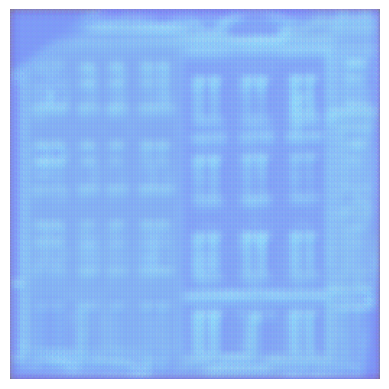

In [ ]:
generator.eval()
for input_img, _ in train_loader:
    input_img = input_img.to(device)
    fake_img = generator(input_img).detach().cpu()
    fake_img = (fake_img + 1) / 2  # scale [-1,1] → [0,1]

    plt.imshow(fake_img.squeeze().permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break


In [ ]:
torch.save(generator.state_dict(), "pix2pix_generator.pth")


In [ ]:
from google.colab import files
files.download("pix2pix_generator.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>